# Training an SRCNN model

In [1]:
import tensorflow as tf
from glob import glob

# Import data loader
from data_loader import MultipleDataLoader

# Import model
from SRGAN import SRGAN
from SRCNN import SRCNN

from training_helpers import discriminator_loss, compute_loss, clearMSE_metric, train_step_gan

from supreshelper import *

import matplotlib.pyplot as plt

### The input to our model is composed of the 4 most visible LR images combined with the median LR hence the number of channel is 5

In [2]:
lr_channels = 5
data_dir = "DataTFRecords/"
DataLoader = MultipleDataLoader(data_dir)

### We define the tf data object with proper properties for training

In [3]:
batch_size = 4

# List tfrecords files
train_files = glob(data_dir +  "train/*/*/multiple.tfrecords")
    
# Create a tf dataset
train_dataset = tf.data.TFRecordDataset(train_files)

# TODO augment
# Map each file to the parsing funciton, enabling data augmentation
train_dataset = train_dataset.map(lambda x: DataLoader.parse_multiple_fixed(x, augment=False, num_lrs = lr_channels), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# reshuffle_each_iteration works only when combined with repeat
#train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(len(train_files))

# Set the batch size
# TODO batch size
train_dataset = train_dataset.batch(batch_size)

### Building the SRGAN model

Load pretrained generator (SRCNN), not using pretraining for now

In [4]:
#custom_object = {'compute_loss':compute_loss, 'clearMSE_metric':clearMSE_metric}
#pre_trained = tf.keras.models.load_model("Model/SRCNN/30.hdf5", custom_objects=custom_object)
#pre_trained.save_weights("gen_weights.h5")

In [5]:
generator = SRCNN(channel_dim = lr_channels, number_residual_block = 3, include_batch_norm = False).model
#generator.load_weights("gen_weights.h5")

In [6]:
srgan = SRGAN(generator, channel_dim=lr_channels, include_batch_norm = False)
model = srgan.model
generator = srgan.generator
discriminator = srgan.discriminator

### Define initial learning rate and optimizer

In [7]:
optimizer_gen = tf.keras.optimizers.Adam(0.0001)
optimizer_discr = tf.keras.optimizers.Adam(0.0001)

In [8]:
disc_losses = []
gen_losses = []

In [9]:
gen_train = True

for epoch in range(10):
    
    # Loss changes while training but faster than recomputing twice
    disc_loss = 0
    gen_loss = 0
    for lrs, hr in train_dataset:
        gl, dl = train_step_gan(lrs, hr, generator, discriminator, optimizer_gen, optimizer_discr, gen_train)
        gen_loss += gl
        disc_loss += dl
        
        # We only train gen after 50 epoch:
        #if epoch == 30:
            #gen_train = True

    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 5 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        # todo
        pass

    if (epoch + 1) % 1 == 0:
        print('epoch: ' + str(epoch) + ' current losses: (gen / disc) ' + str(gen_loss.numpy()) + " / " + str(disc_loss.numpy()))

W0719 03:16:23.115251 140550282753856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch: 0 current losses: (gen / disc) 7503.7466 / 86.32178
epoch: 1 current losses: (gen / disc) 1402.2393 / 102.10337
epoch: 2 current losses: (gen / disc) 964.39374 / 120.770035
epoch: 3 current losses: (gen / disc) 964.02856 / 122.64641


KeyboardInterrupt: 

4 Epoch

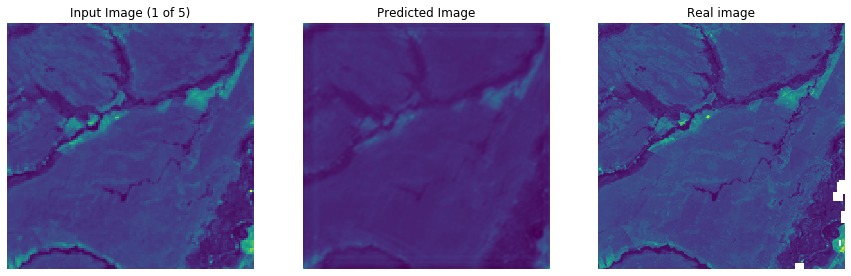

In [10]:
from training_helpers import show_pred
for lrs, hr in train_dataset.take(1):
    show_pred(generator, lrs, hr, max_lr=lr_channels)

### Compute score on train set

In [ ]:
train_records = glob(data_dir +  "train/*/*/multiple.tfrecords")
train_scenes = glob(data_dir +  "train/*/*/")
    
train_score = tf.data.TFRecordDataset(train_records)
train_score = train_score.map(lambda x: DataLoader.parse_multiple_fixed(x, augment=False, num_lrs = lr_channels))
# reshuffle_each_iteration works only for the repeat operation
train_score = train_score.batch(1)

In [ ]:
scores = []
i = 0
for lrs, hr in train_score:
    sr = model(lrs)
    scores.append(score_image_fast(sr[0][:,:,0].numpy(), train_scenes[i]))
    i += 1  

In [ ]:
print(np.mean(scores))

### Generate some predictions

In [ ]:
from training_helpers import show_pred
custom_object = {'compute_loss':compute_loss, 'clearMSE_metric':clearMSE_metric}
model = tf.keras.models.load_model("Model/SRCNN/30.hdf5", custom_objects=custom_object)

In [ ]:
for lrs, hr in train_score.take(50):
    show_pred(model, lrs, hr, max_lr=lr_channels)